In [46]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"

opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [47]:
!pip install torch torchvision transformers opencv-python scikit-learn

In [48]:
import os

# Check the dataset directory
!ls /kaggle/input/multimodal-disaster-dataset-bangla/

'Multimodal Disaster Bangla Dataset'


In [49]:
import pandas as pd

# Load the CSV file
csv_path = '/kaggle/input/multimodal-disaster-dataset-bangla/Multimodal Disaster Bangla Dataset/Thesis.csv'
df = pd.read_csv(csv_path,encoding="utf-8")
df.head()

,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1,কুমিল্লা,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1,কুমিল্লা,NaN
2,3,কুমিল্লা,flood,1,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1,ফেনী,NaN


In [50]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from torchvision import transforms
import os

In [52]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['label', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [53]:

# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [54]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('csebuetnlp/banglabert')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [55]:
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertForSequenceClassification

# Load the tokenizer for BanglaBERT
tokenizer = BertTokenizer.from_pretrained('csebuetnlp/banglabert')

# If you want to use BanglaBERT for classification:
model = BertForSequenceClassification.from_pretrained('csebuetnlp/banglabert')

# If you actually wanted DistilBERT, change the tokenizer accordingly:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.

In [56]:
# Tokenize
train_encodings = tokenizer(list(train_data['caption']), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(valid_data['caption']), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_data['caption']), truncation=True, padding=True, max_length=512)

# Prepare labels
train_labels = list(train_data['level'])
val_labels = list(valid_data['level'])
test_labels = list(test_data['level'])

In [57]:
#Create custom dataset class
class DisasterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = DisasterDataset(train_encodings, train_labels)
val_dataset = DisasterDataset(val_encodings, val_labels)
test_dataset = DisasterDataset(test_encodings, test_labels)

# Load the model
model = BertForSequenceClassification.from_pretrained('csebuetnlp/banglabert', num_labels=2)

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.

In [58]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
from datasets import DatasetDict  # Assuming you are using Hugging Face Datasets

training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    evaluation_strategy="epoch",
    logging_strategy="epoch",   # Log at the end of every epoch
    logging_dir='/kaggle/working/logs',
    logging_steps=10,           # Log every 10 steps
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch",       # Save model every epoch
    logging_first_step=True,
    load_best_model_at_end=True,
    report_to="none",
)


# Set up the Trainer
trainer = Trainer(
    model=model,                         # The model to be trained
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset (ensure it's defined)
    eval_dataset=val_dataset,            # Validation dataset (ensure it's defined)
)

# Start training
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.582800,0.951933
2,0.323000,0.151202
3,0.126700,0.259709
4,0.078700,0.356360
5,0.047900,0.232554
6,0.013900,0.488279
7,0.028600,0.217151
8,0.012000,0.226646
9,0.007100,0.228804
10,0.000800,0.224223


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=1040, training_loss=0.1222805719392804, metrics={'train_runtime': 437.2285, 'train_samples_per_second': 37.761, 'train_steps_per_second': 2.379, 'total_flos': 1374457208763600.0, 'train_loss': 0.1222805719392804, 'epoch': 10.0})

In [59]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def evaluate_model(trainer, eval_dataset):
    predictions, labels, _ = trainer.predict(eval_dataset)
    
    # Convert logits to predicted classes
    preds = torch.argmax(torch.tensor(predictions), dim=1).numpy()
    
    # Compute accuracy
    accuracy = accuracy_score(labels, preds)

    # Compute precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    # Generate classification report
    report = classification_report(labels, preds, target_names=["Class 0", "Class 1"])

    return accuracy, precision, recall, f1, report, labels, preds
# Evaluate the model on the validation dataset
test_accuracy, test_precision, test_recall, test_f1, test_report, all_labels, all_preds = evaluate_model(trainer, val_dataset)

# Print out the results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("Classification Report:\n", test_report)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Accuracy: 0.9437
Test Precision: 0.9447
Test Recall: 0.9437
Test F1 Score: 0.9440
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.91      0.95      0.93       206
     Class 1       0.97      0.94      0.95       345

    accuracy                           0.94       551
   macro avg       0.94      0.94      0.94       551
weighted avg       0.94      0.94      0.94       551



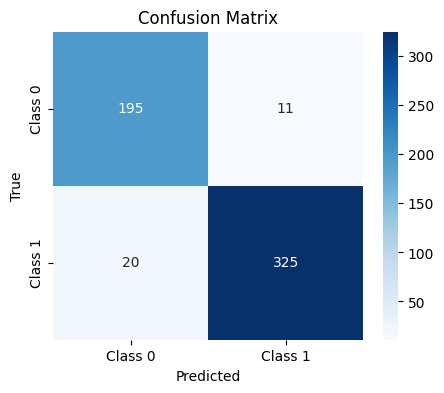

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()